# Brain Tumor Data

Here we estimate a generalized lasso model (sparse fused lasso) via the constrained lasso. 

In this example, we use a version of the comparative genomic hybridization (CGH) data from [Bredel et al. (2005)](../references.md#2) that was modified and studied by [Tibshirani and Wang (2008)](../references.md#6)

The dataset here contains CGH measurements from 2 glioblastoma multiforme (GBM) brain tumors. [Tibshirani and Wang (2008)](../references.md#6) proposed using the sparse fused lasso to approximate the CGH signal by a sparse, piecewise constant function in order to determine the areas with non-zero values, as positive (negative) CGH values correspond to possible gains (losses). The sparse fused lasso ([Tibshirani et al., 2005](../references.md#5)) is given by


$$\begin{split}
\text{minimize} \hspace{1em} \frac{1}{2} ||\boldsymbol{y}-\boldsymbol{\beta}||_2^2 + \rho_1||\boldsymbol{\beta}||_1 + \rho_2\sum_{j=2}^p |\beta_j - \beta_{j-1}| \hspace{5em} (1)
\end{split}$$

The sparse fused lasso is a special case of the generalized lasso with the penalty matrix. Therefore, the problem $(1)$ is equivalent to the following: 

$$\begin{split} 
\text{minimize} \hspace{1em} \frac{1}{2} ||\boldsymbol{y}-\boldsymbol{X\beta}||_2^2 + \rho ||\boldsymbol{D\beta}||_1 \hspace{5em} (2)
\end{split}$$

where 

$$\boldsymbol{D} = \begin{pmatrix} 
1 & -1 &     &    	  &       & 	& \\
  & 1  & -1  &    	  &  		&	& \\
  &    &  1  & -1 	  & 		& 	& \\
  &		&		& \ddots & \ddots &  & \\
  &		&		&		 &			& 1 & -1 \\
1 &  &     &    	  &       & 	& \\
  & 1  &   &    	  &  		&	& \\
  &    &  \ddots  &  	  & 		& 	& \\
  & 	&          & & \ddots & & \\
  &		&		     &      &       & 1 & \\
  &		&		&		 &			    &  & 1\\  
\end{pmatrix} \in \mathbb{R}^{(2P-1)\times p}.$$

As discussed in [Gaines, B.R. and Zhou, H., (2016)](../references.md), the sparse fused lasso can be reformulated and solved as a constrained lasso problem. (For details of the reformulation, see Section 2 of [[3](../references.md)]). Here, we demonstrate solving the generalized lasso problem as constrained lasso, using ``genlasso.jl`` in **ConstrainedLasso** package. 



In [1]:
using ConstrainedLasso


Use "abstract type Loss end" instead.


We load and organize the data first. Here, `y` is the response vector. The design matrix `X` is an identity matrix since the objective function in ``(1)`` does not involve `X`. 

In [2]:
y = readdlm(joinpath(Pkg.dir("ConstrainedLasso"), "docs/src/demo/misc/tumor.txt"))

990×1 Array{Float64,2}:
  0.333661 
 -0.152838 
  0.101485 
 -0.0342123
  0.344761 
  0.151108 
  0.798318 
  0.282754 
  0.116233 
 -0.232173 
 -0.754577 
  1.06762  
 -0.017392 
  ⋮        
 -0.170825 
 -0.161826 
 -0.348987 
 -0.001227 
 -0.221422 
  0.552795 
 -0.603429 
 -0.447907 
 -0.317569 
 -0.728202 
 -0.505593 
 -0.147661 

In [3]:
n = p = size(y, 1)
X = eye(n)

990×990 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

First we create a penalty matrix `D`. 

In [4]:
D = [eye(p-1) zeros(p-1, 1)] - [zeros(p-1, 1) eye(p-1)]

989×990 Array{Float64,2}:
 1.0  -1.0   0.0   0.0   0.0   0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
 0.0   1.0  -1.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   1.0  -1.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   1.0  -1.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   1.0  -1.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   0.0   1.0  …   0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   0.0   0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
 ⋮          

In [5]:
β̂path, ρpath = genlasso(X, y; D = D)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] isnan(::Array{Float64,1}) at ./deprecated.jl:57
 [3] populate_solution!(::ECOS.ECOSMathProgModel, ::Convex.Problem, ::Dict{UInt64,Tuple{Int64,Int64}}, ::Array{Convex.ConicConstr,1}) at /Users/juhyun-kim/.julia/v0.6/Convex/src/solution.jl:118
 [4] #solve!#25(::Bool, ::Bool, ::Bool, ::Function, ::Convex.Problem) at /Users/juhyun-kim/.julia/v0.6/Convex/src/solution.jl:38
 [5] #solve!#24(::Array{Any,1}, ::Function, ::Convex.Problem, ::ECOS.ECOSSolver) at /Users/juhyun-kim/.julia/v0.6/Convex/src/solution.jl:13
 [6] #find_ρmax#61(::Array{Float64,2}, ::Array{Float64,1}, ::Array{Float64,2}, ::Array{Float64,1}, ::Array{Bool,1}, ::ECOS.ECOSSolver, ::Function, ::Array{Float64,2}, ::Array{Float64,1}) at /Users/juhyun-kim/.julia/v0.6/ConstrainedLasso/src/classopath.jl:694
 [7] (::ConstrainedLasso.#kw##find_ρmax)(::Array{Any,1}, ::ConstrainedLasso.#find_ρmax, ::Array{Float64,2}, ::Array{Float64,1}) at ./<missing>:0
 [8] #lsq_cla

([-0.0178926 -0.0046696 … 0.333516 0.333644; -0.0178926 -0.0046696 … -0.152548 -0.152803; … ; -0.0178926 -0.0212612 … -0.505593 -0.505593; -0.0178926 -0.0212612 … -0.147807 -0.147679], [138.641, 135.983, 112.914, 86.7231, 38.6934, 33.6742, 33.4223, 29.0274, 16.4677, 14.8989  …  0.00312939, 0.0022499, 0.00129357, 0.00118782, 0.000983542, 0.000623544, 0.000246343, 0.00017132, 0.000145322, 0.0])

In [6]:
β̂path

990×989 Array{Float64,2}:
 -0.0178926  -0.0046696   0.118695    0.258754   …   0.333516     0.333644  
 -0.0178926  -0.0046696   0.118695    0.258754      -0.152548    -0.152803  
 -0.0178926  -0.0046696   0.118695    0.258754       0.101194     0.10145   
 -0.0178926  -0.0046696   0.118695    0.258754      -0.0339217   -0.0341772 
 -0.0178926  -0.0046696   0.118695    0.258754       0.34447      0.344726  
 -0.0178926  -0.0046696   0.118695    0.258754   …   0.151399     0.151143  
 -0.0178926  -0.0046696   0.118695    0.258754       0.798027     0.798283  
 -0.0178926  -0.0046696   0.118695    0.258754       0.282754     0.282754  
 -0.0178926  -0.0046696   0.118695    0.258754       0.116233     0.116233  
 -0.0178926  -0.0046696   0.118695    0.258754      -0.232173    -0.232173  
 -0.0178926  -0.0046696   0.118695    0.258754   …  -0.754287    -0.754542  
 -0.0178926  -0.0046696   0.118695    0.258754       1.06733      1.06759   
 -0.0178926  -0.0046696   0.118695    0.258754    

In [7]:
ρpath

989-element Array{Float64,1}:
 138.641      
 135.983      
 112.914      
  86.7231     
  38.6934     
  33.6742     
  33.4223     
  29.0274     
  16.4677     
  14.8989     
  13.7994     
  11.5303     
   7.45317    
   ⋮          
   0.00336078 
   0.00319116 
   0.00312939 
   0.0022499  
   0.00129357 
   0.00118782 
   0.000983542
   0.000623544
   0.000246343
   0.00017132 
   0.000145322
   0.0        

We plot the constrained lasso solution path below. 


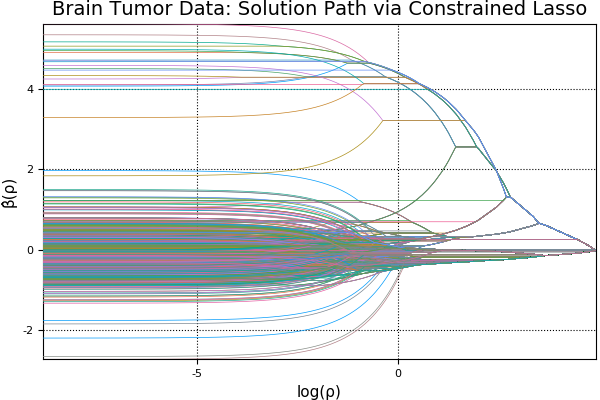

In [40]:
using Plots; pyplot(); 
ρnewpath = ρpath[1:end-1] # exclude ρ=0
βnewpath = β̂path[:, 1:end-1]
plot(log.(ρnewpath), βnewpath', label="", xaxis = ("log(ρ)"), yaxis = ("β̂(ρ)"), width=0.5)
title!("Brain Tumor Data: Solution Path via Constrained Lasso")

In [ ]:
savefig("misc/tumor1.svg");

Now let's compare our estimates with those from generalized lasso.  

Variables `lambda_path` and `beta_path_fused` are lambda values and estimated beta coefficients, respectively, obtained from `genlasso` package in `R`. 

In [8]:
lambda_path = readdlm(joinpath(Pkg.dir("ConstrainedLasso"),"docs/src/demo/misc/lambda_path.txt"))

989×1 Array{Float64,2}:
 138.641      
 135.983      
 112.914      
  86.7231     
  38.6934     
  33.6742     
  33.4223     
  29.0274     
  16.4677     
  14.8989     
  13.7994     
  11.5303     
   7.45317    
   ⋮          
   0.00336078 
   0.00319116 
   0.00312939 
   0.0022499  
   0.00129357 
   0.00118782 
   0.000983542
   0.000623544
   0.000246343
   0.00017132 
   0.000145321
   1.7577e-5  

In [9]:
beta_path_fused = readdlm(joinpath(Pkg.dir("ConstrainedLasso"),"docs/src/demo/misc/beta_path_fused.txt"))[2:end, :]

990×989 Array{Float64,2}:
 -0.0178926  -0.0046696   0.118694    0.258754   …   0.333516     0.333644  
 -0.0178926  -0.0046696   0.118694    0.258754      -0.152548    -0.152803  
 -0.0178926  -0.0046696   0.118694    0.258754       0.101194     0.10145   
 -0.0178926  -0.0046696   0.118694    0.258754      -0.0339217   -0.0341772 
 -0.0178926  -0.0046696   0.118694    0.258754       0.344471     0.344726  
 -0.0178926  -0.0046696   0.118694    0.258754   …   0.151399     0.151143  
 -0.0178926  -0.0046696   0.118694    0.258754       0.798027     0.798283  
 -0.0178926  -0.0046696   0.118694    0.258754       0.282754     0.282754  
 -0.0178926  -0.0046696   0.118694    0.258754       0.116233     0.116233  
 -0.0178926  -0.0046696   0.118694    0.258754      -0.232173    -0.232173  
 -0.0178926  -0.0046696   0.118694    0.258754   …  -0.754287    -0.754542  
 -0.0178926  -0.0046696   0.118694    0.258754       1.06733      1.06759   
 -0.0178926  -0.0046696   0.118694    0.258754    

The following figure plots generalized lasso solution path. 


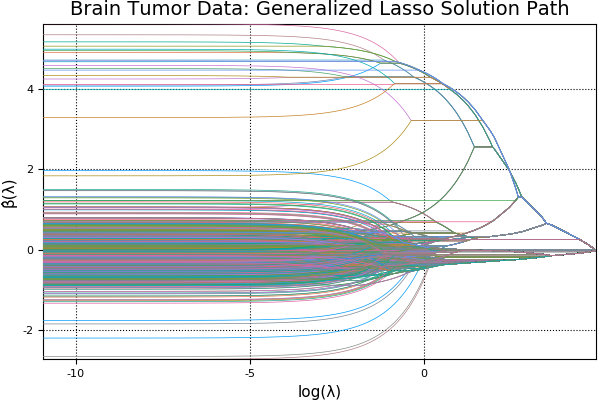

In [39]:
plot(log.(lambda_path), beta_path_fused', label="", xaxis = ("log(λ)"), yaxis = ("β̂(λ)"), width=0.5)
title!("Brain Tumor Data: Generalized Lasso Solution Path")

In [ ]:
savefig("misc/tumor2.svg")

Now we extract common values of $\rho$ and compare estimates at those values. 

In [10]:
sameρ = intersect(round.(ρpath, 4), round.(lambda_path, 4))
sameρ_err = Float64[]
for i in eachindex(sameρ)
 curρ = sameρ[i]
 idx1 = findmin(abs.(ρpath - curρ))[2]
 idx2 = findmin(abs.(lambda_path - curρ))[2]
 push!(sameρ_err, maximum(abs.(β̂path[:, idx1] - beta_path_fused[:, idx2])))
end
sameρ_err

988-element Array{Float64,1}:
 1.22121e-9
 2.47148e-9
 4.33354e-9
 4.3335e-9 
 3.64469e-8
 4.41366e-8
 3.35e-8   
 4.53911e-8
 4.29568e-7
 3.18004e-7
 4.94452e-7
 2.62003e-7
 3.8775e-7 
 ⋮         
 5.00008e-7
 4.89495e-7
 4.87999e-7
 4.95e-7   
 4.78989e-7
 4.86001e-7
 4.96003e-7
 4.99498e-7
 4.86994e-7
 4.86994e-7
 4.89997e-7
 4.83994e-7

Below are the mean, median, and maximum of the errors between estimated coefficients at common ``\rho`` values. 

In [11]:
println([mean(sameρ_err); median(sameρ_err); maximum(sameρ_err)])

[4.77914e-7, 4.80866e-7, 5.00013e-7]


*Follow the [link](https://github.com/Hua-Zhou/ConstrainedLasso.jl/blob/master/docs/src/demo/tumor.ipynb) to access the .ipynb file of this page.*